# Муравьиные алгоритмы для решения задачи коммивояжера
### Визуализация поиска решения и анализ качества алгоритма

Для построение графиков и анимаций будем использовать библиотеки `matplotlib` и `plotly.graph_objects`. 
Добавим все необходимые библиотеки.

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
sys.path.append('/content/gdrive/MyDrive/TSP/algorithms')
sys.path.append('/content/gdrive/MyDrive/TSP')

In [4]:
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns
import copy

sns.set(style="darkgrid")

from ant import AntColony
from tsp import TSP
from typing import List
import numpy as np

In [5]:
tsp_path = '/content/gdrive/MyDrive/TSP/'

Создадим функцию для сохранения информации о городах для TSP из текстового файла в `DataFrame`

In [6]:
def get_cities_df(file_path: str):
    cities_df = pd.read_csv(file_path, sep=' ', header=None)
    cities_df.columns = ['name', 'x', 'y']
    return cities_df

In [7]:
file_path = tsp_path + 'tests/50cities_1.txt'
cities_df = get_cities_df(file_path)

Посмотрим на сохраненный нами тест для 50 городов.

In [8]:
cities_df.head(7)

name    x    y
0     1  230  166
1     2   92   66
2     3   39   47
3     4  218  207
4     5   64  197
5     6  133  130
6     7  238   91

Напишем функцию инициализации задачи коммивояжера

In [9]:
def init_tsp(cities_df: pd.DataFrame):
    cities: List[TSP.City] = []
    for _, row in cities_df.iterrows():
        id, x, y = row['name'], row['x'], row['y']
        cities.append(TSP.City(id, int(x), int(y)))
    return TSP(cities)

Теперь передадим задачу в муравьиный алгоритм и запустим ее

In [10]:
tsp = init_tsp(cities_df)

as_settings = AntColony.Settings(iterations=100)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

In [11]:
%%time
dist = as_colony.solve(tsp, logging=True)

print("Ant System: ", dist)

Ant System:  2024.0593613926867
CPU times: user 47.5 s, sys: 575 ms, total: 48.1 s
Wall time: 48.1 s


Реализуем функцию, которая будет рисовать график-анимацию нахождения решения

In [10]:
def plot_tsp(cities_df, tsp, title):
    points = go.Scatter(x=cities_df['x'], y=cities_df['y'], mode='markers',
                        marker=dict(color='#5D69B1', size=10), name='Город',
                        text = ["Название: {}".format(name) for name in cities_df['name'] ])

    paths_history, distances_history = tsp.get_solutions_history()
    answer = paths_history[-1]

    path = go.Scatter(x=answer[0], y=answer[1], mode='lines', name="Маршрут")

    button = {
            "type": "buttons",
            "buttons": [
                {
                    "label": "Запустить",
                    "method": "animate",
                    "args": [None, {"frame": {"duration": 180},
                                    "fromcurrent": True}],
                },
                {
                    "label": "Остановить",
                    "method": "animate",
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                }
            ],
        }

    frames = []
    for i in range(len(paths_history)):
        path = go.Scatter(x=paths_history[i][0], y=paths_history[i][1], mode='lines', name="Маршрут")
        layout = go.Layout(updatemenus=[button], 
                           title_text=f"Маршрут, найденный {title} за {i + 1} итераций, " +
                                      f"длина маршрута = {distances_history[i]}")
        frame = go.Frame(data=[points, path], layout=layout)
        frames.append(frame)


    fig = go.Figure(data=[points, path], frames=frames, layout=layout)
    fig.show()

In [13]:
plot_tsp(cities_df, tsp, "Ant System")

Так как шаг муравья выбирается случайным образом с учетом вероятности, то от запуска к запуску мы будем получать различные ответы. Поэтому сделаем функцию, которая будет запускать алгоритм несколько раз, чтобы учитывать случайность и приблизиться к наикротчайшему решению.

__Почему нельзя просто увеличить количество итераций?__
Потому что нам необходимо полностью обновить всю случайность алгоритма. При увеличении итераций феромон на ребрах графа продолжает изменяться и влияет на выбор муравьев. При полном перезапуске весь феромон очищается и, таким образом, муравьи начинают поиск без стимуляции, вызванной стигмергией.

In [11]:
def run(tsp: TSP, ant_colony: AntColony, attempts: int, logging=True):
    min_dist = float('inf')
    best_tsp = None
    
    for attempt in range(attempts):
        tsp.clear_answer()
        dist = ant_colony.solve(tsp, logging)
        if dist < min_dist:
            min_dist = dist
            if logging:
                best_tsp = copy.deepcopy(tsp)
    
    return best_tsp if logging else min_dist

Теперь мы можем собрать все в одну функцию, которая по пути к файлу будет строить график-анимацию. Более того, нами были реализованы различные модификации муравьиного алгоритма (помимо муравьиной системы "Ant System"), поэтому в функции мы будем принимать экземпляр класса `AntColony` с выставленными настройками, то есть с выбором модификации, и заданными параметрами.

In [12]:
def get_solution(file_path: str, ant_colony: AntColony, attempts=1, logging=True):
    cities_df = get_cities_df(file_path)
    tsp = init_tsp(cities_df)
    return cities_df, run(tsp, ant_colony, attempts, logging)

In [31]:
file_path = tsp_path + 'tests/16cities_1.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=0.1, beta=3, rho=0.4, ants=15, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, 5)
plot_tsp(cities_df, tsp, 'Ant System')

Чтобы сохранять полученные графики, сделаем функцию, которая по имени будет подбирать порядковый номер так, чтобы старые картинки не перезатирались.

In [13]:
import os.path

def get_file_name(out_name):
    i = 1
    file_name = tsp_path + f"aco_results/{out_name}_{i}.svg"
    while os.path.exists(file_name):
        i += 1
        file_name = tsp_path + f"aco_results/{out_name}_{i}.svg"
    
    return file_name

In [15]:
get_file_name('convergence')

'/content/gdrive/MyDrive/TSP/aco_results/convergence_12.svg'

In [14]:
def plot_convergence(tsp, title, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    _, distances = tsp.get_solutions_history()
    plt.plot(grid, distances, color='blue', label='Найденный маршрут')
    
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' + 'в зависимости от числа итераций', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('convergence'))
    plt.show()

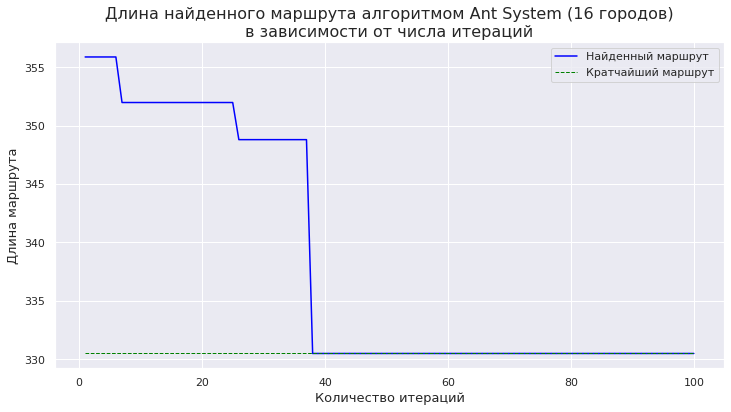

In [35]:
plot_convergence(tsp, 'Ant System (16 городов)', answer=330.5054664199449)

In [15]:
def plot_research(tsp, title, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    plt.plot(grid, tsp.get_iterations(), color='blue', linewidth=1, label='Наилучшее решение на каждой итерации')
    _, distances = tsp.get_solutions_history()
    plt.plot(grid, distances, color='red', label='Наилучшее решение с начала работы алгоритма')
    
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Номер итерации', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Исследование процесса решения алгоритмом {title}', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('best_result'))
    plt.show()

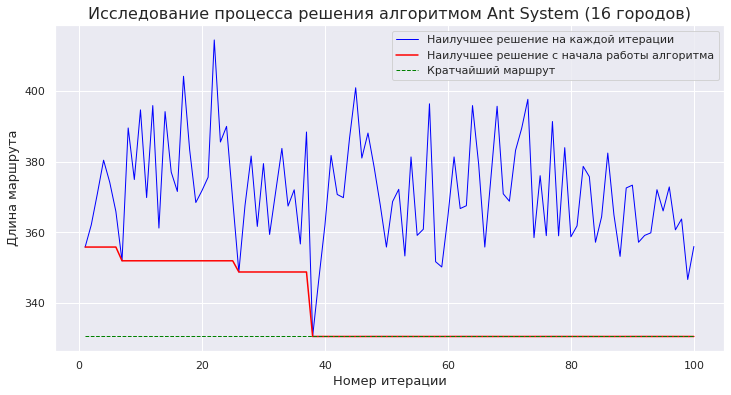

In [37]:
plot_research(tsp, 'Ant System (16 городов)', answer=330.5054664199449)

In [16]:
def plot_deviation(tsp, title):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    rmse = tsp.get_ants_distances().std(axis=1)
    
    plt.plot(grid, rmse, color='blue', linewidth=1)
    
    plt.xlabel('Номер итерации', fontsize=13)
    plt.ylabel('Среднее квадратическое отклонение', fontsize=13)
    plt.title(f'Исследование RMSE решений по итерациям алгоритма {title}', fontsize=16)
    
    plt.savefig(get_file_name('deviation'))
    plt.show()

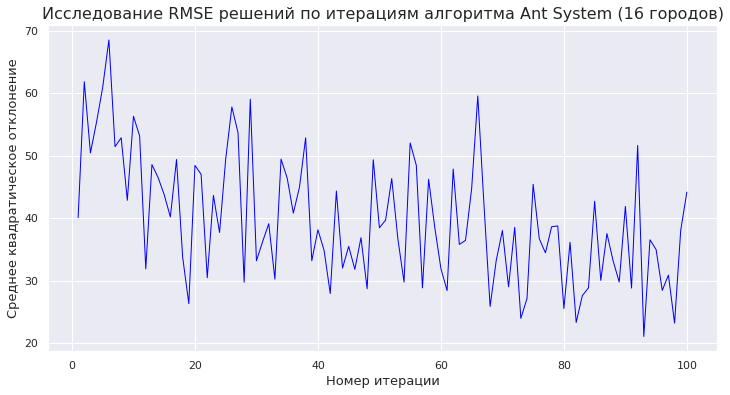

In [39]:
plot_deviation(tsp, 'Ant System (16 городов)')

Теперь займемся поиском оптимальных параметров. Для этого напишем поиск по сетке.

In [18]:
from typing import Iterable
from itertools import product

def grid_parameters(parameters: dict) -> Iterable:
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

In [42]:
%%time
file_path = tsp_path + 'tests/16cities_1.txt'
params = {
    'ants': [10, 15, 16, 18],
    'alpha': [.1, .5, 1, 1.2],
    'beta': [2, 3, 4, 5],
    'rho': [.4, .5, .6],
    'iterations': [100]
}

best_settings = None
best_dist = float('inf')

for settings in grid_parameters(params):
    as_settings = AntColony.Settings(**settings)
    as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
    _, dist = get_solution(file_path, as_colony, attempts=5, logging=False)
    if dist < best_dist:
        best_dist = dist
        best_settings = settings

print(f'Лучшее расстояние: {best_dist} с параметрами', best_settings)

Лучшее расстояние: 330.505466419945 с параметрами {'ants': 10, 'alpha': 0.1, 'beta': 3, 'rho': 0.4, 'iterations': 100}
CPU times: user 30min 47s, sys: 27.9 s, total: 31min 15s
Wall time: 30min 32s


Теперь исследуем разные значения каждого из параметров. При этом будем фиксировать остальные параметры оптимальным значением.

In [17]:
def plot_various_ants(file_path, title, iterations, ants, alpha, beta, rho, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    for ant in ants:
        as_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, ants=ant, iterations=iterations)
        as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
        cities_df, tsp = get_solution(file_path, as_colony, 5)
        
        _, distances = tsp.get_solutions_history()
        plt.plot(grid, distances, label=f'{ant} муравьев')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от количества муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('ants_number'))
    plt.show()

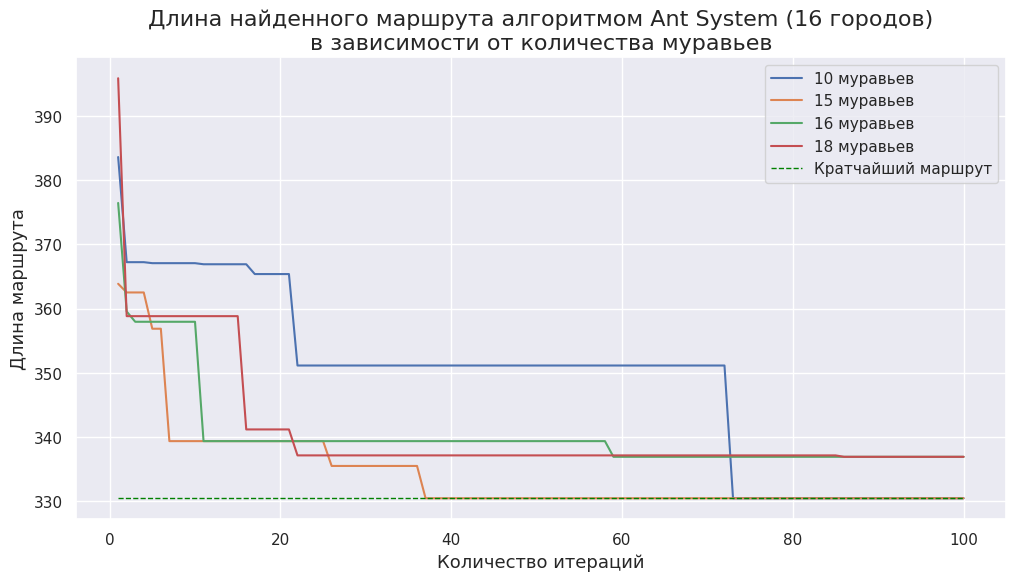

In [ ]:
file_path = tsp_path + 'tests/16cities_1.txt'
ants = [10, 15, 16, 18]

plot_various_ants(file_path, 'Ant System (16 городов)', iterations=100, ants=ants, 
                  alpha=.1, beta=3, rho=.4, answer=330.5054664199449)

In [20]:
def plot_various_params(file_path, title, iterations, ants, params, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    alpha_len = len(params['alpha'])
    beta_len = len(params['beta'])
    rho_len = len(params['rho'])
    
    for i in range(max(alpha_len, beta_len, rho_len)):
        alpha = params['alpha'][i % alpha_len]
        beta = params['beta'][i % beta_len]
        rho = params['rho'][i % rho_len]
        as_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, ants=ants, iterations=iterations)
        as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
        cities_df, tsp = get_solution(file_path, as_colony, 5)
        
        _, distances = tsp.get_solutions_history()
        plt.plot(grid, distances, label=f'$\\alpha =${alpha}, $\\beta =${beta}, $\\rho =${rho}')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от параметров для {ants} муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('params'))
    plt.show()

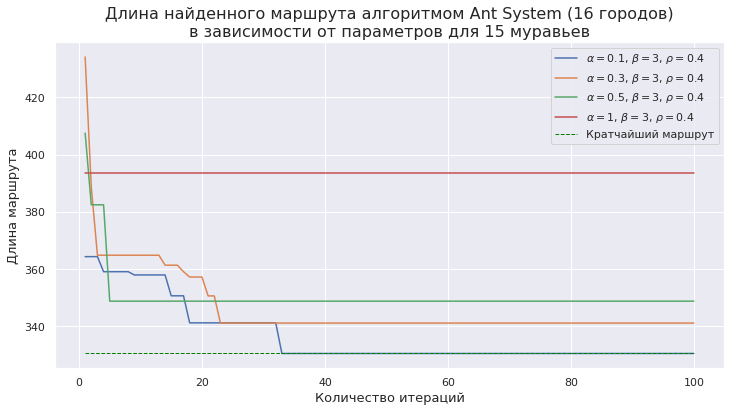

In [25]:
file_path = tsp_path + 'tests/16cities_1.txt'
params = {
    'alpha': [.1, .3, .5, 1],
    'beta': [3],
    'rho': [.4]
}

plot_various_params(file_path, 'Ant System (16 городов)', iterations=100, ants=15, 
                    params=params, answer=330.5054664199449)

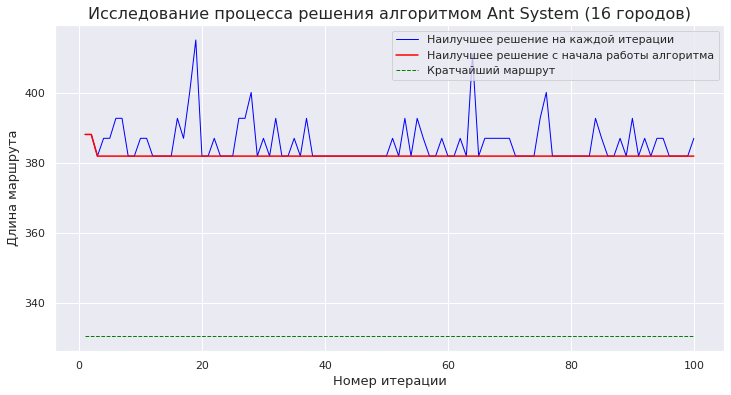

CPU times: user 2.58 s, sys: 48.3 ms, total: 2.62 s
Wall time: 2.62 s


In [49]:
%%time
file_path = tsp_path + 'tests/16cities_1.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=1, beta=3, rho=0.4, ants=15, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp_16 = get_solution(file_path, as_colony, attempts=1)
plot_research(tsp_16, 'Ant System (16 городов)', answer=330.5054664199449)

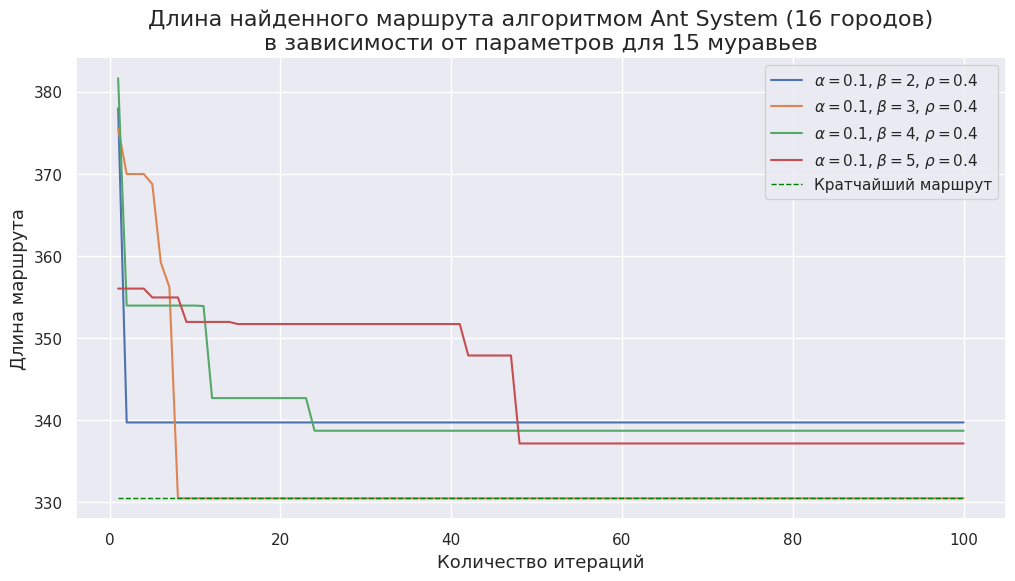

In [ ]:
file_path = 'tests/16cities_1.txt'
params = {
    'alpha': [.1],
    'beta': [2, 3, 4, 5],
    'rho': [.4]
}

plot_various_params(file_path, 'Ant System (16 городов)', iterations=100, 
                    ants=15, params=params, answer=330.5054664199449)

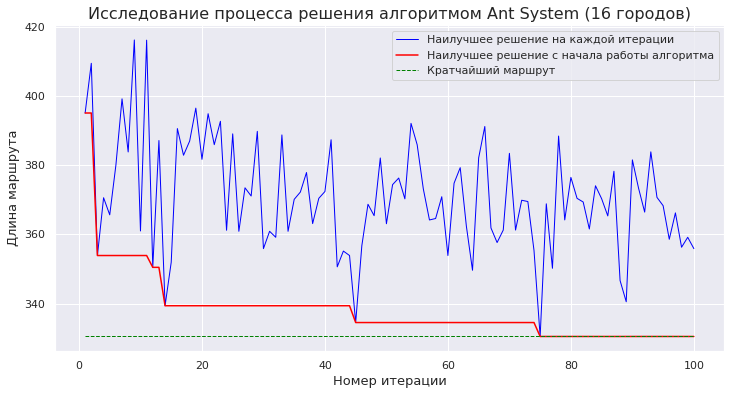

CPU times: user 6.04 s, sys: 56.1 ms, total: 6.1 s
Wall time: 7.26 s


In [73]:
%%time
file_path = tsp_path + 'tests/16cities_1.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=0.1, beta=3, rho=0.4, ants=15, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp_16 = get_solution(file_path, as_colony, attempts=1)
plot_research(tsp_16, 'Ant System (16 городов)', answer=330.5054664199449)

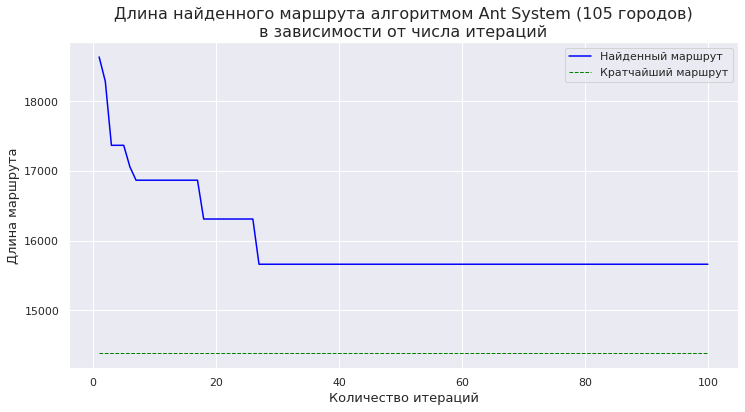

CPU times: user 19min 31s, sys: 12.1 s, total: 19min 43s
Wall time: 19min 35s


In [30]:
%%time
file_path = tsp_path + 'tests/lin105.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=0.5, beta=5, rho=0.2, ants=100, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, attempts=1)
plot_convergence(tsp, 'Ant System (105 городов)', answer=14379)

In [31]:
plot_tsp(cities_df, tsp, 'Ant System')

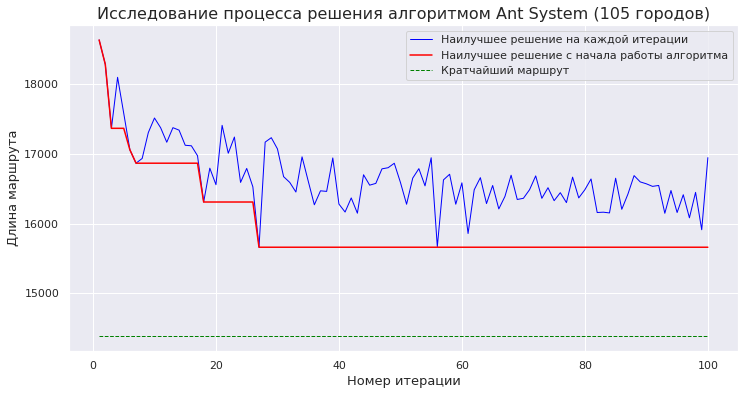

In [32]:
plot_research(tsp, 'Ant System (105 городов)', answer=14379)

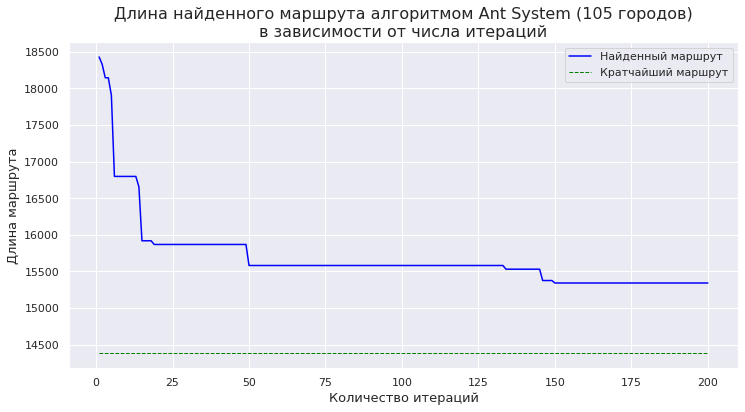

CPU times: user 43min 37s, sys: 21.7 s, total: 43min 59s
Wall time: 43min 49s


In [18]:
%%time
file_path = tsp_path + 'tests/lin105.txt'
iterations = 200
as_settings = AntColony.Settings(alpha=0.5, beta=5, rho=0.2, ants=100, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, attempts=1)
plot_convergence(tsp, 'Ant System (105 городов)', answer=14379)

In [19]:
plot_tsp(cities_df, tsp, 'Ant System')

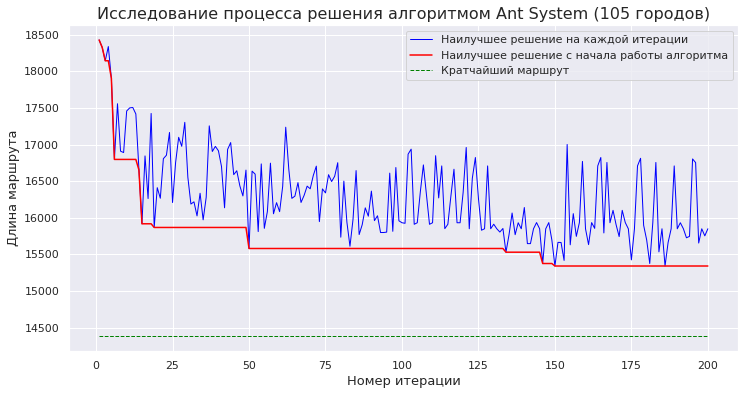

In [20]:
plot_research(tsp, 'Ant System (105 городов)', answer=14379)

In [22]:
tsp.get_iterations()

[18427.772523153497,
 18326.52561610612,
 18143.922677756866,
 18337.87580793336,
 17905.751302092,
 16796.626208065623,
 17557.140105420433,
 16909.302343726373,
 16890.328487407925,
 17457.816398325813,
 17500.349592573326,
 17505.698804496795,
 17417.49478863608,
 16653.906046227425,
 15917.741364616573,
 16844.282791949932,
 16262.478240252845,
 17424.262990353556,
 15867.575004443612,
 16410.745760630707,
 16266.709930005856,
 16807.043886824616,
 16854.068346577315,
 17164.7325580408,
 16208.010881019527,
 16755.511026985852,
 17098.374702825357,
 16975.78255554546,
 17303.05918026519,
 16553.788866934112,
 16187.289557502527,
 16217.595182150515,
 16025.52356303709,
 16334.366701561159,
 15971.857160388316,
 16279.861378344473,
 17254.95033702793,
 16904.901170509667,
 16974.8893638263,
 16914.44271495459,
 16700.632181677876,
 16136.106306055168,
 16933.53020327589,
 17026.62690218332,
 16588.789530980983,
 16641.77938061246,
 16435.58796321996,
 16297.92278111794,
 16650.66137

In [24]:
def plot_various_elitist_ants(file_path, title, iterations, ants, elitists, alpha, beta, rho, attempts=5, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    for elitist in elitists:
        eas_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, 
                                          ants=ants, elitist=elitist, iterations=iterations)
        eas_colony = AntColony(AntColony.Variation.ELITIST_ANT_SYSTEM, eas_settings)
        cities_df, tsp = get_solution(file_path, eas_colony, attempts)
        
        _, distances = tsp.get_solutions_history()
        plt.plot(grid, distances, label=f'{elitist} элитных муравьев')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от количества элитных муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('elitis_ants_number'))
    plt.show()

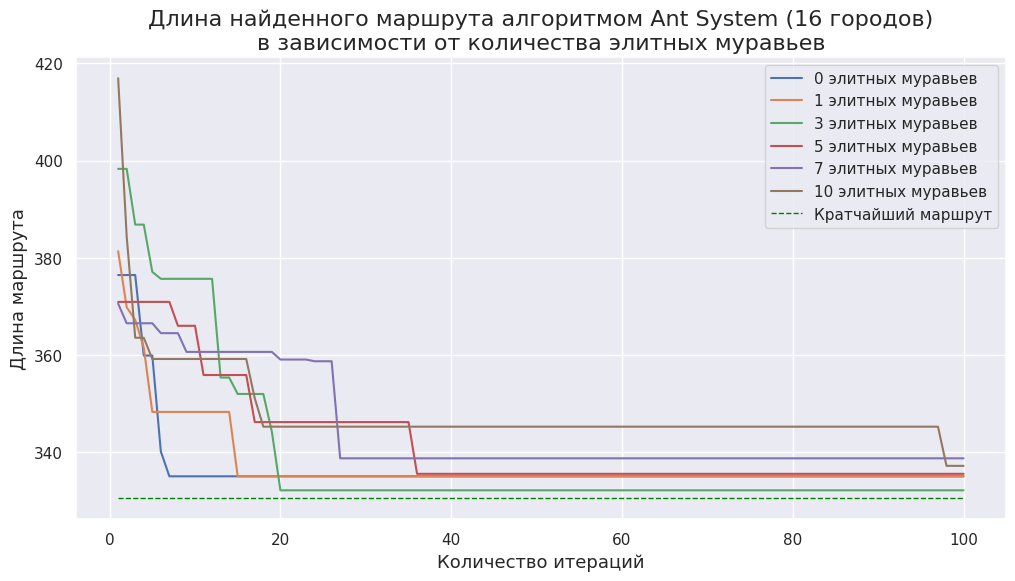

In [ ]:
file_path = 'tests/16cities_1.txt'
elitists = [0, 1, 3, 5, 7, 10]

plot_various_elitist_ants(file_path, 'Ant System (16 городов)', iterations=100, ants=15, 
                          elitists=elitists, alpha=.1, beta=3, rho=.4, answer=330.5054664199449)

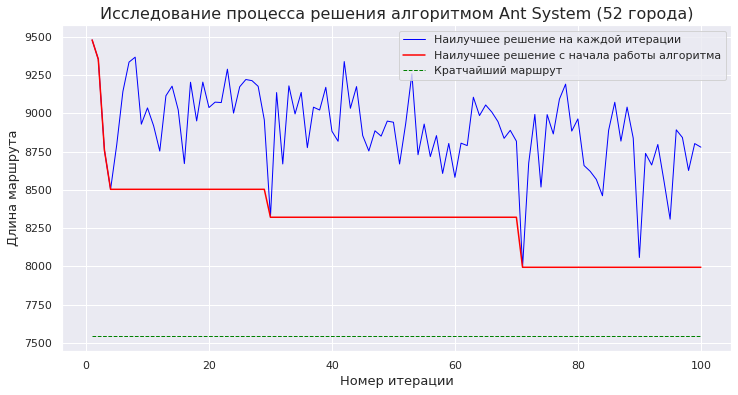

CPU times: user 3min 56s, sys: 2.63 s, total: 3min 59s
Wall time: 4min 4s


In [21]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 100
as_settings = AntColony.Settings(alpha=.2, beta=5, rho=0.2, ants=50, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp = get_solution(file_path, as_colony, attempts=1)
plot_research(tsp, 'Ant System (52 города)', answer=7542)

In [22]:
plot_tsp(cities_df, tsp, 'Ant System')

In [28]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
params = {
    'ants': [50],
    'alpha': [.1, .5, 1],
    'beta': [2, 3, 4, 5],
    'rho': [.2, .4, .6],
    'iterations': [100]
}

best_settings = None
best_dist = float('inf')

for settings in grid_parameters(params):
    as_settings = AntColony.Settings(**settings)
    as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)
    _, dist = get_solution(file_path, as_colony, attempts=2, logging=False)
    print(f'Расстояние: {dist} с параметрами', settings)
    if dist < best_dist:
        best_dist = dist
        best_settings = settings

print(f'Лучшее расстояние: {best_dist} с параметрами', best_settings)

Расстояние: 11307.820648542094 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 2, 'rho': 0.2, 'iterations': 100}
Расстояние: 10828.188626161775 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 2, 'rho': 0.4, 'iterations': 100}
Расстояние: 10762.138834790845 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 2, 'rho': 0.6, 'iterations': 100}
Расстояние: 8841.268414859682 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 3, 'rho': 0.2, 'iterations': 100}
Расстояние: 8475.279183400802 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 3, 'rho': 0.4, 'iterations': 100}
Расстояние: 8338.031791814068 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 3, 'rho': 0.6, 'iterations': 100}
Расстояние: 8386.563769034896 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 4, 'rho': 0.2, 'iterations': 100}
Расстояние: 8143.679073305009 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 4, 'rho': 0.4, 'iterations': 100}
Расстояние: 8121.062844857355 с параметрами {'ants': 50, 'alpha': 0.1, 'beta': 4, 'rho': 0.6,

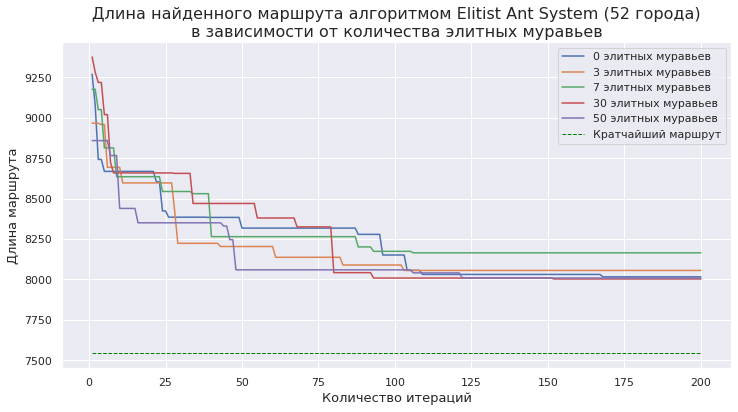

CPU times: user 44min 22s, sys: 16.8 s, total: 44min 39s
Wall time: 44min 40s


In [56]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
elitists = [0, 3, 7, 30, 50]

plot_various_elitist_ants(file_path, 'Elitist Ant System (52 города)', iterations=200, ants=50, 
                          elitists=elitists, alpha=.2, beta=5, rho=.2, attempts=1, answer=7542)

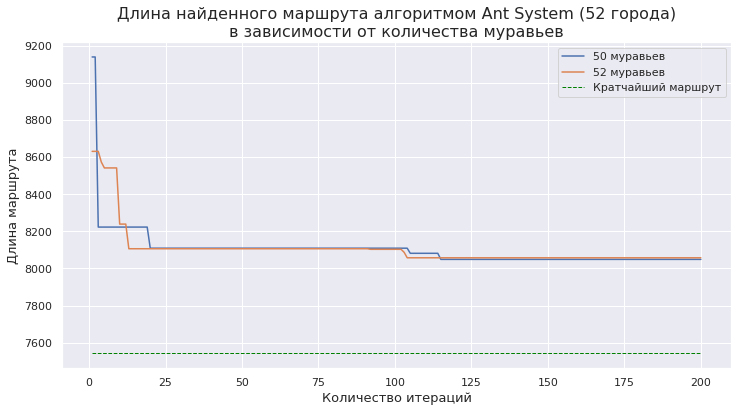

In [57]:
file_path = tsp_path + 'tests/berlin52.txt'
ants = [50, 52]

plot_various_ants(file_path, 'Ant System (52 города)', iterations=200, ants=ants, 
                  alpha=.2, beta=5, rho=.2, answer=7542)

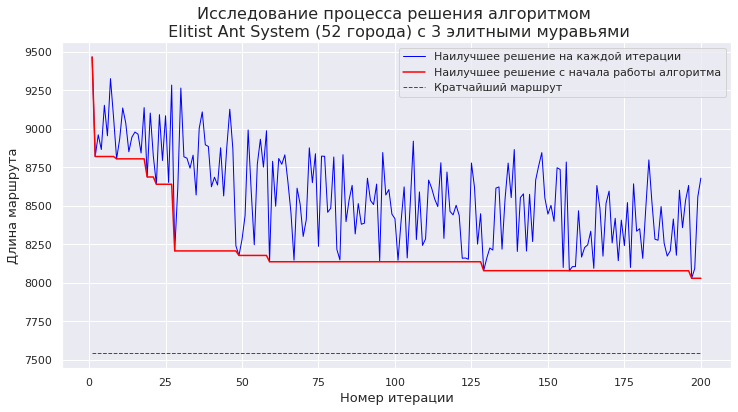

CPU times: user 8min 10s, sys: 3.57 s, total: 8min 14s
Wall time: 8min 20s


In [23]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 200
eas_settings = AntColony.Settings(alpha=.2, beta=5, rho=0.2, ants=50, iterations=iterations, elitist=3)
eas_colony = AntColony(AntColony.Variation.ELITIST_ANT_SYSTEM, eas_settings)

cities_df, tsp = get_solution(file_path, eas_colony, attempts=1)
plot_research(tsp, '\n Elitist Ant System (52 города) с 3 элитными муравьями', answer=7542)

In [26]:
def plot_various_elitist_ants_new(file_path, title, iterations, ants, elitists, alpha, beta, rho, attempts=1, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)
    
    for elitist in elitists:
        ras_settings = AntColony.Settings(alpha=alpha, beta=beta, rho=rho, 
                                          ants=ants, elitist=elitist, iterations=iterations)
        ras_colony = AntColony(AntColony.Variation.RANKBASED_ANT_SYSTEM, ras_settings)
        cities_df, tsp_t = get_solution(file_path, ras_colony, attempts)
        
        _, distances = tsp_t.get_solutions_history()
        print('Elitist: ', elitist, ' dist: ', distances[-1])
        plt.plot(grid, distances, label=f'{elitist} элитных муравьев')
        
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Длина найденного маршрута алгоритмом {title}\n' 
              + f'в зависимости от количества элитных муравьев', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('elitis_ants_number'))
    plt.show()

In [29]:
# file_path = tsp_path + 'tests/berlin52.txt'
# elitists = [3, 5, 6, 7, 9]

# plot_various_elitist_ants_new(file_path, 'Rankbased Ant System (52 города)', iterations=100, ants=50, 
#                               elitists=elitists, alpha=.2, beta=5, rho=.2, answer=7542)

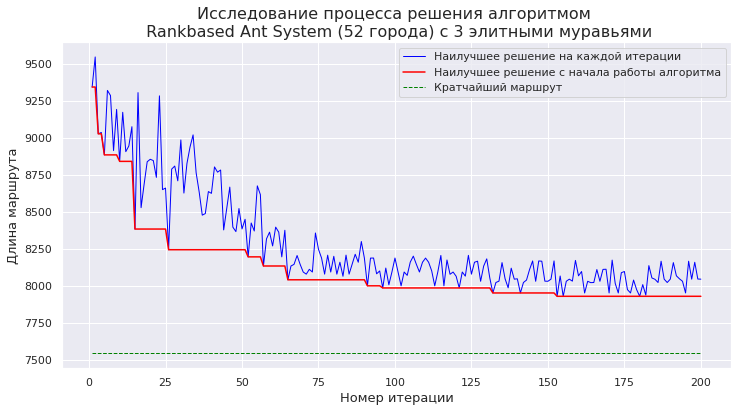

CPU times: user 11min 17s, sys: 5.31 s, total: 11min 23s
Wall time: 11min 27s


In [24]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 200
ras_settings = AntColony.Settings(alpha=.2, beta=5, rho=0.2, ants=50, iterations=iterations, elitist=3)
ras_colony = AntColony(AntColony.Variation.RANKBASED_ANT_SYSTEM, ras_settings)

cities_df, tsp = get_solution(file_path, ras_colony, attempts=1)
plot_research(tsp, '\n Rankbased Ant System (52 города) с 3 элитными муравьями', answer=7542)

In [25]:
plot_tsp(cities_df, tsp, 'Rankbased Ant System')

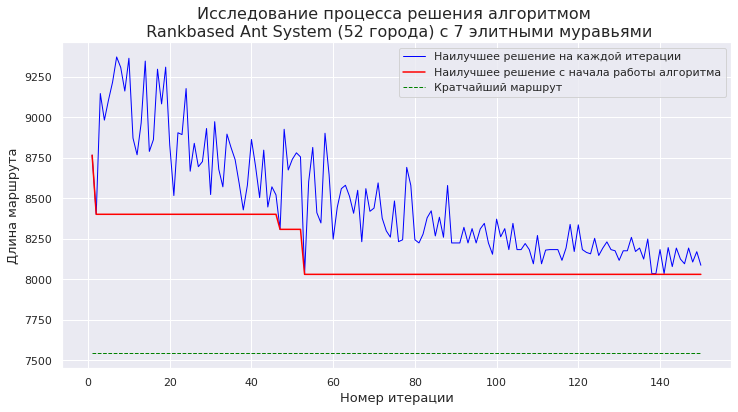

CPU times: user 6min 42s, sys: 2.13 s, total: 6min 44s
Wall time: 6min 43s


In [31]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 150
ras_settings = AntColony.Settings(alpha=.1, beta=5, rho=0.4, ants=50, iterations=iterations, elitist=7)
ras_colony = AntColony(AntColony.Variation.RANKBASED_ANT_SYSTEM, ras_settings)

cities_df, tsp = get_solution(file_path, ras_colony, attempts=1)
plot_research(tsp, '\n Rankbased Ant System (52 города) с 7 элитными муравьями', answer=7542)

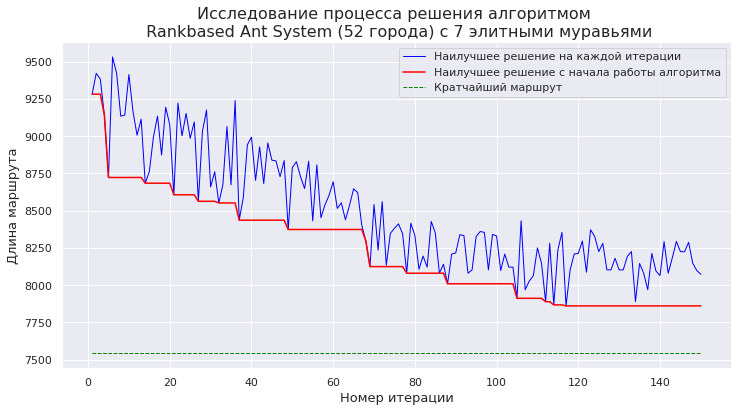

CPU times: user 6min 35s, sys: 2.22 s, total: 6min 37s
Wall time: 6min 36s


In [32]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 150
ras_settings = AntColony.Settings(alpha=.1, beta=5, rho=0.4, ants=50, iterations=iterations, elitist=7)
ras_colony = AntColony(AntColony.Variation.RANKBASED_ANT_SYSTEM, ras_settings)

cities_df, tsp = get_solution(file_path, ras_colony, attempts=1)
plot_research(tsp, '\n Rankbased Ant System (52 города) с 7 элитными муравьями', answer=7542)

In [33]:
plot_tsp(cities_df, tsp, 'Rankbased Ant System')

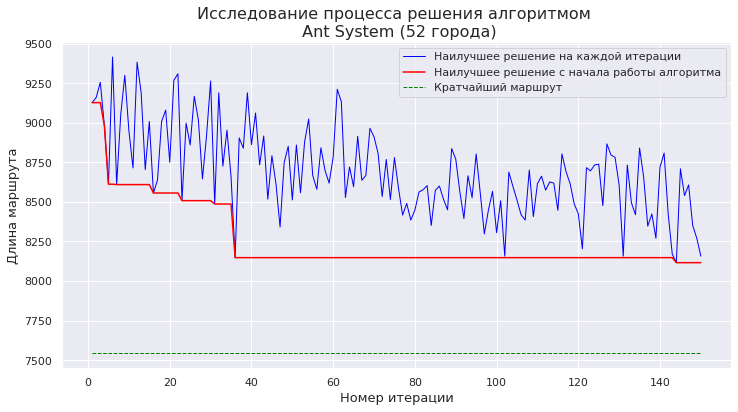

CPU times: user 6min 42s, sys: 2.28 s, total: 6min 44s
Wall time: 6min 50s


In [36]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 150
as_settings = AntColony.Settings(alpha=.1, beta=5, rho=0.4, ants=50, iterations=iterations)
as_colony = AntColony(AntColony.Variation.ANT_SYSTEM, as_settings)

cities_df, tsp_as = get_solution(file_path, as_colony, attempts=1)
plot_research(tsp_as, '\n Ant System (52 города)', answer=7542)

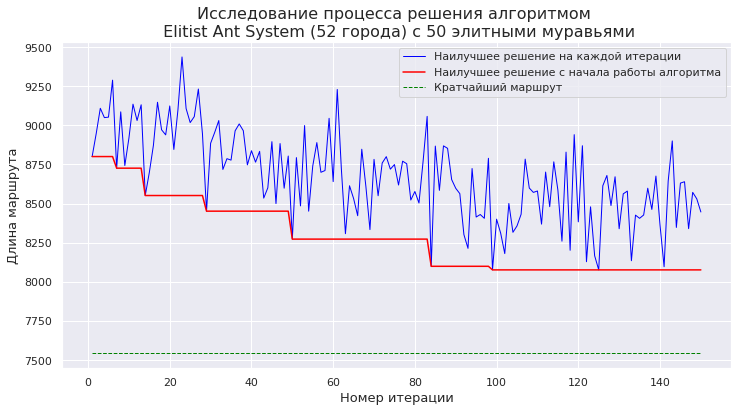

CPU times: user 6min 24s, sys: 2.13 s, total: 6min 26s
Wall time: 6min 27s


In [37]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 150
eas_settings = AntColony.Settings(alpha=.1, beta=5, rho=0.4, ants=50, iterations=iterations, elitist=50)
eas_colony = AntColony(AntColony.Variation.ELITIST_ANT_SYSTEM, eas_settings)

cities_df, tsp_eas = get_solution(file_path, eas_colony, attempts=1)
plot_research(tsp_eas, '\n Elitist Ant System (52 города) с 50 элитными муравьями', answer=7542)

In [44]:
def plot_comparison(aco, cities_n, answer=0):
    plt.figure(figsize=(12, 6))
    grid = np.arange(1, iterations + 1)

    for i in range(len(aco['tsp'])):
      _, distances = aco['tsp'][i].get_solutions_history()
      plt.plot(grid, distances, color=aco['color'][i], label=aco['label'][i])
    
    if answer != 0:
        plt.plot(grid, np.full(iterations, answer), color='green', 
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')
    
    plt.xlabel('Количество итераций', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Сравнение различных муравьиных алгоритмов \n на тесте из {cities_n} городов', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('comparison'))
    plt.show()

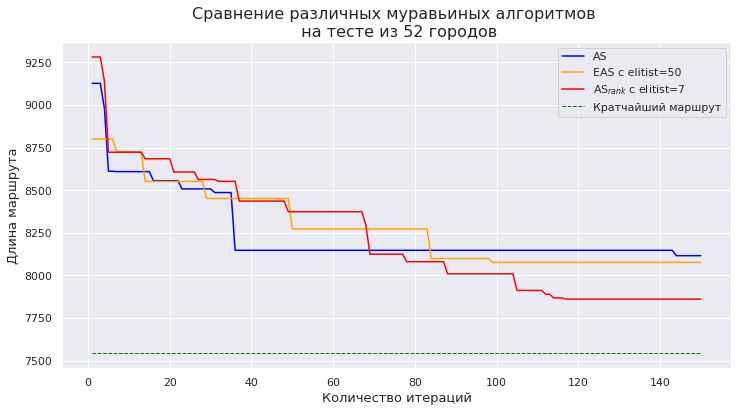

In [46]:
aco = {
    'tsp': [tsp_as, tsp_eas, tsp],
    'label': [r'AS', r'EAS c elitist=50', r'AS$_{rank}$ c elitist=7'],
    'color': ['blue', 'orange', 'red']
}
plot_comparison(aco, 52, answer=7542)

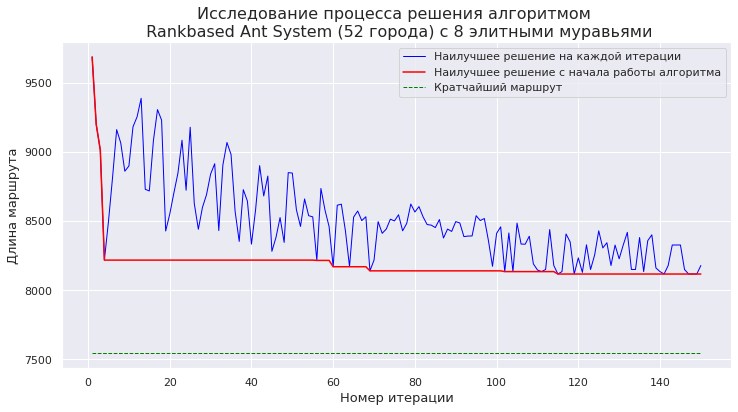

CPU times: user 6min 40s, sys: 2.14 s, total: 6min 42s
Wall time: 6min 42s


In [64]:
%%time
file_path = tsp_path + 'tests/berlin52.txt'
iterations = 150
ras_settings = AntColony.Settings(alpha=.1, beta=5, rho=0.4, ants=50, iterations=iterations, elitist=8)
ras_colony = AntColony(AntColony.Variation.RANKBASED_ANT_SYSTEM, ras_settings)

cities_df, tsp_ras = get_solution(file_path, ras_colony, attempts=1)
plot_research(tsp_ras, '\n Rankbased Ant System (52 города) с 8 элитными муравьями', answer=7542)

In [62]:
plot_tsp(cities_df, tsp_ras, 'Rankbased Ant System')

In [23]:
def plot_comparison_algos(tsp_ants, tsp_ga, answer=0):
    plt.figure(figsize=(12, 6))

    plt.plot(tsp_ants.get_timestamps(), tsp_ants.get_iterations(), color='blue', label='Муравьиный алгоритм')
    # plt.plot(tsp_ga.get_timestamps(), tsp_ga.get_iterations(), color='orange', label='Генетический алгоритм')

    if answer != 0:
        plt.plot(tsp_ants.get_timestamps(), np.full(len(tsp_ants.get_timestamps()), answer), color='green',
                 linestyle='--', linewidth=1, label='Кратчайший маршрут')


    plt.xlabel('Время', fontsize=13)
    plt.ylabel('Длина маршрута', fontsize=13)
    plt.title(f'Сравнения маршрутов, полученных различными алгоритмами', fontsize=16)
    plt.legend(loc=1)
    
    plt.savefig(get_file_name('comparison'))
    plt.show()